# Data Cleaning and EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import numpy as np
import math
import glob
import seaborn as sns
from nltk.corpus import stopwords

## 1. Read in Data

I iteratively stored tabs into different CSVs during scraping to avoid losing data if my computer shut down. So  we'll want to read all these files and combine them into one

In [3]:
# Combine csvs
all_files=glob.glob("/Users/eshantarneja/Documents/DataScience/data/rawData/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, encoding='latin-1')
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
df.head()

,url,new_x,new_y,chordOrder,chordList,topInfo,songArtist
0,https://tabs.ultimate-guitar.com/tab/dolly-par...,['Country'],[1970],"['G', 'C', 'G', 'C', 'D', 'G', 'C', 'G', 'C', ...","['G', 'C', 'D']",[],Its All Wrong But Its All Right chords by Doll...
1,https://tabs.ultimate-guitar.com/tab/dolly-par...,"['Country', 'Folk', 'Folk']","[1970, 1970, 1940]","['Am', 'C', 'G', 'Am', 'G', 'Am', 'Am', 'C', '...","['Am', 'C', 'G']","['Difficulty: intermediate', 'Tuning: E A D G ...",Jolene chords by Dolly Parton
2,https://tabs.ultimate-guitar.com/tab/dolly-par...,['Country'],[1970],"['Em', 'G', 'D', 'Em', 'D', 'Em', 'Em', 'G', '...","['Em', 'G', 'D']","['Difficulty: novice', 'Tuning: E A D G B E', ...",Jolene chords by Dolly Parton
3,https://tabs.ultimate-guitar.com/tab/dolly-par...,"['Country', 'Folk']","[1970, 1970]","['Dm', 'F', 'C', 'Dm', 'C', 'Dm', 'F', 'C', 'D...","['Dm', 'F', 'C']",[],Jolene chords by Dolly Parton
4,https://tabs.ultimate-guitar.com/tab/dolly-par...,"['Country', 'Country', 'Folk', 'Folk']","[1970, 1940, 1970, 1940]","['Am', 'Am', 'C', 'G', 'Am', 'G', 'Am', 'Am', ...","['Am', 'C', 'G', 'Em']","['Difficulty: novice', 'Tuning: E A D G B E', ...",Jolene chords by Dolly Parton


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 7 columns):
url           9997 non-null object
new_x         9997 non-null object
new_y         9997 non-null object
chordOrder    9997 non-null object
chordList     9997 non-null object
topInfo       9997 non-null object
songArtist    9997 non-null object
dtypes: object(7)
memory usage: 546.8+ KB


We have about 10,000 data points to work with all in one data frame now! Our data set has 7 total columns. They are poorly named right now, but they give us 
1. the url of the tab 
2. the genre 
3. decade 
4. chords in order they are played 
5. unique chords in the song 
6. disparate info about the songs that are scraped from top of tab 
7. song name and artist

## 2. Clean up Low Hanging Fruit

My data set is quite expansive, but it also rather dirty. Before getting into any analysis I need to do some basic cleaning. There is more cleaning to come throughout the analysis as I identify more errors, so this section is focused more instead on cleaning up the low hanging fruit.

There are a couple of issues within this raw data that I can see just by looking at it. Lets clean those up to start.

1. Song and Artist are in a field together (i.e Dust Bowl chords by 10,000 Maniacs). We'll want to seperate these into their own fields

2. All of the lists were read in as strings. I can see that by all of them being read as "objects". I learned that reading and writing in csvs loses python formatting (this is what pckl files are great for apparently...I had always heard of these...never knew why people used them). I'll go ahead and convert those back into lists though.

3. The topInfo column has really disparate information about the song. This data is found at the top of the chord page and usually contains Key, Capo, and Tuning...but sometimes has only some of that info, and also sometimes has random facts about the song. I'll break these into their own fields if they exist, and if there is extra info, I'll put it in a column called "other"

4. I know from my original file combining that there are quite a few duplicates in the data. I.e these Urls were found in multiple genres and decades, but have the exact same tab (shown by url). That is why the genre and decades are stored as list because I combined all the info from each of these into one before scraping the song to avoid duplicate work. I'll take the unique set of genres and decades for each entry. I.e ["Folk","Folk", "Rock", "Rock"] -> ["Folk", "Rock"]. I'll decide what to do with multiple genres/decades later...

In [5]:
def cleanSongArtist(raw):
#     takes in songArtist field and splits into Song and Artist columns seperately
    song=np.NaN
    artist=np.NaN
    saList=raw.split(" chords by ")
    if len(saList)==2:       
        song=saList[0]
        artist=saList[1]
    return pd.Series([song,artist])


def stringToList(row):
#     all lists were read into CSVS as strings. Use literal eval to convert back to list format
    chordList=literal_eval(row['chordList'])
    chordOrder=literal_eval(row['chordOrder'])
    songInfo=literal_eval(row['topInfo'])
    genre=literal_eval(row['new_x'])
    decade=literal_eval(row['new_y'])
    return pd.Series([chordList, chordOrder, genre, decade, songInfo])


def cleanSongInfo(songInfo):
#     break songInfo field into its parts
    diff = np.NaN
    tuning = np.NaN
    capo = np.NaN
    key = np.NaN
    other = np.NaN
# loop through since some values may be missing (i.e no capo listed). weird values stored in the "other" column
    if type(songInfo)==int:
        print(songInfo)
    for i in songInfo:
        infoList=i.split(': ')
        if len(infoList)==2:
            infoType=infoList[0]
            value=infoList[1]
            if infoType=='Difficulty':
                diff=value
            elif infoType=='Tuning':
                tuning=value
            elif infoType=='Capo':
                capo=value
            elif infoType=='Key':
                key=value
            else:
                other=i
        else:
            other=i            
    return pd.Series([diff, tuning, capo, key, other])

# remove duplicate genre and decades from data
def removeDuplicates(row):
    decade=list(set(row['decade']))
    genre=list(set(row['genre']))
    return pd.Series([decade, genre])

# def cleanUrl(rawUrl):
#     urlList=rawUrl.split('/')
#     urlShort=urlList[4:6]
#     artistName=urlShort[0].replace('-',' ')
#     songName=urlShort[1].split('-chords')[0].replace('-',' ')
#     return pd.Series([artistName, songName])


# df[['artistName', 'songName']]=df.url.apply(cleanUrl)
df[['song','artist']]=df.songArtist.apply(cleanSongArtist)
df[['chordList', 'chordOrder', 'genre', 'decade', 'songInfo']]=df.apply(stringToList, axis=1)
df[['difficulty', 'tuning', 'capo', 'key','other']]=df.songInfo.apply(cleanSongInfo)
df[['decade','genre']]=df.apply(removeDuplicates, axis=1)
df.drop(['new_x', 'new_y', 'songInfo', 'topInfo', 'songArtist'], axis=1, inplace=True)
df.rename(columns={'chordList':'uniqueChords'},inplace=True)


df.head()   


,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other
0,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[G, C, G, C, D, G, C, G, C, D, G, C, G, C, D, ...","[G, C, D]",Its All Wrong But Its All Right,Dolly Parton,[Country],[1970],NaN,NaN,NaN,NaN,NaN
1,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, C, G, Am, G, Am, Am, C, G, Am, G, Am, Am,...","[Am, C, G]",Jolene,Dolly Parton,"[Folk, Country]","[1970, 1940]",intermediate,E A D G B E,4th fret,NaN,NaN
2,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Em, G, D, Em, D, Em, Em, G, D, Em, Em, G, D, ...","[Em, G, D]",Jolene,Dolly Parton,[Country],[1970],novice,E A D G B E,4th fret,NaN,NaN
3,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Dm, F, C, Dm, C, Dm, F, C, Dm, C, Dm, Dm, F, ...","[Dm, F, C]",Jolene,Dolly Parton,"[Folk, Country]",[1970],NaN,NaN,NaN,NaN,NaN
4,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, Am, C, G, Am, G, Am, Am, C, G, Am, G, Em,...","[Am, C, G, Em]",Jolene,Dolly Parton,"[Folk, Country]","[1970, 1940]",novice,E A D G B E,4th fret,C#m,NaN


Looks much better!

## 3. EDA

Let's now do a basic exploratory analysis of our data. We will probably have to do some cleanup as we expose more issues, but we're at a good enough spot to get started. While the main focus of this analysis is on the chords, I still want to get a baseline understanding of this data set first. So I'll step through each field one by one until we reach the chords. We'll go a bit more in depth there!

### Decades

We'll start with the decades field. Lets see the breakdown of how much of our data is from each decade. This column is of type "list", because we seem to have some songs with multiple decades (i.e the same song was scraped from multiple decade pages). Right from the start, this jumped out to me as something that could be off - so let's check that out here.

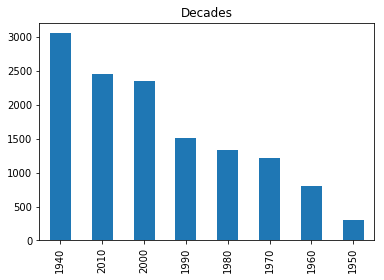

In [6]:
pd.Series(df.decade.sum()).value_counts().plot(kind="bar", title="Decades")

Wow, lots of song from the 1940's....seems a bit off. After a quick check on the ultimate guitar website I realized that there are no 1940's chords at all. Turns out there was a bug in my web scraper that was adding in that date as a filter. I should have only been going back to 1950. 

This might explain why there are multiple decades for some songs. A song can only be from one decade. Lets see if all of these multi-decade songs have a 1940 in them.

In [7]:
a=df[df['decade'].map(len)>1]
print('Entries with multiple decade values: ', a.size)
mask = a.decade.apply(lambda x: 1940 in x)
print('Multiple decade values that contain 1940: ', a[mask].size)
newCol=a['decade'].map(len)
print('Maximum length of duplicate values: ', max(newCol))

Entries with multiple decade values:  36528
Multiple decade values that contain 1940:  36528
Maximum length of duplicate values:  2


Awesome news...all of these entries that have multiple decade values have 2 decades in their list, and one of those decades is a 1940. Also, when I check out those filters on ultimate guitar, it seems the rest of the info is correct...so all I need to do is remove the "1940" decade tag from them and the rest of the data is still good values. We shouldn't have any more duplicate decades after that.

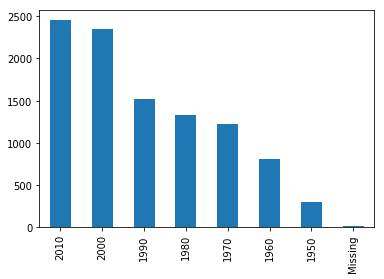

In [8]:
# remove 1940s from data. found during initial data analysis that these values were brought in incorrectly...no 1940 data online. when scraping for 1940 it just removes that filter but keeps the other (genre)
def removeFourtys(decades):
    newList=[]
    for dec in decades:
        if dec!=1940:
            newList.append(dec)
    if len(newList)>0:
        return str(max(newList))
    else:
        return np.NaN

df['decade']=df.decade.apply(removeFourtys)
df.fillna('Missing').decade.value_counts().plot(kind='bar')


Much better...After removing 1940 as a possible decade, we see that most of our tabs are from recent decades. The amount of tabs decreases as we go further back in time. There are a couple of tabs now missing decades since all they had were "1940". We could either clean those up by hand or just remove them when we deal with missing values.

(PS I've also gone ahead and fixed that bug in my scraper in case any one else wants to use it!) 

### Genres

We'll start again by just looking at the breakdown of genres. We have mostly all categorical data, so bar and pie charts are our best option here.

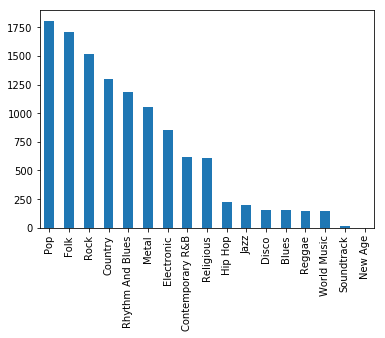

In [9]:
pd.Series(df.genre.sum()).value_counts().plot(kind="bar")

Similar to decades, a song potentially has multiple genres. However, unlike decades, having multiple genres is definitely possible. Let's exlore our songs that have multiple genres.

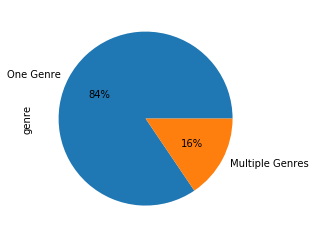

In [10]:
a=df[df['genre'].notnull()].genre.apply(lambda x: "One Genre" if len(x)==1 else "Multiple Genres")
a.value_counts().plot(kind='pie', autopct='%1.0f%%')

Text(0, 0.5, 'Count')

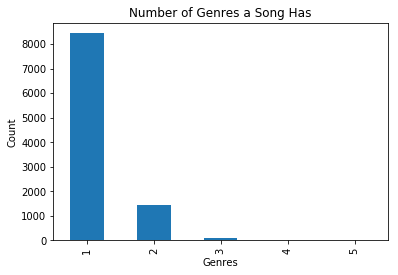

In [11]:
ax =df['genre'].map(len).value_counts().plot(kind='bar', title='Number of Genres a Song Has')
ax.set_xlabel("Genres")
ax.set_ylabel("Count")

So most songs only have one genre, but we still have quite a few with multiple (some even have 5). There's no reason to try and choose one genre for each song, as it could be interesting to to explore songs that cross genres, how they are related, etc. However, a list may not be the best format for comparing them. Lets try and see what the most popular crossover genres are. We will transform the field to be a sorted tuple for direct comparisons and hashing ability.

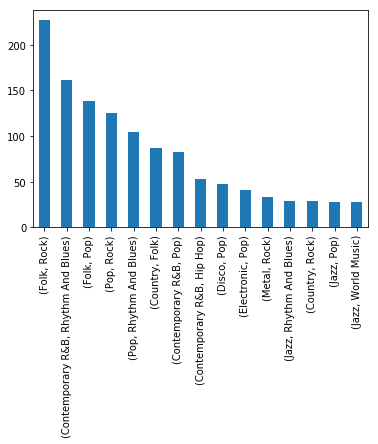

In [12]:
df['genre']=df.genre.apply(sorted).apply(tuple)
df[df['genre'].map(len)>1]['genre'].value_counts().sort_values(ascending=False).head(15).plot(kind='bar')

These all seem legit! 

Another thing I'm interested to see is how our decades and genres are related. I would assume that most of our Pop songs are from 2000's on, and Jazz would be earlier on. Lets try to graph this breakdown. It will be a good excercise in playing with pandas group by's as well

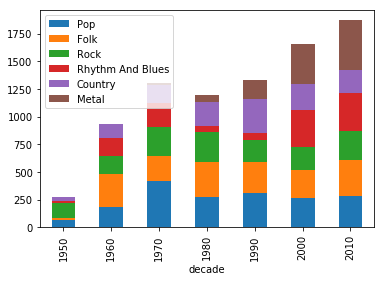

In [13]:
groups=df.groupby('decade')['genre'].apply(lambda x: list(x)).apply(lambda x: [item for sublist in x for item in sublist]).apply(lambda x: pd.Series(x).value_counts())
groups[['Pop','Folk','Rock','Rhythm And Blues','Country','Metal']].plot(kind='bar', stacked=True)

Nevermind! There actually is a fairly even split among all decades. This is honestly unexpected. This means that when I filtered on UG by "2010+Pop", I recieved a similar amount of data for the filter "1980+Pop". This is great that we have a balanced data set though! That was one of the reasons of scraping in the way I did.

### Songs and Artists

Lets take a look at our artists first. I wonder how many diferent artists we have in this dataset?

In [14]:
print("Unique artists in data set: ", df.artist.nunique())

Unique artists in data set:  872


Interesting, so we only have 872 unique artist, but we have over 10000 tabs. That means we have multiple songs per artist. Lets see which artists have the most songs in our dataset

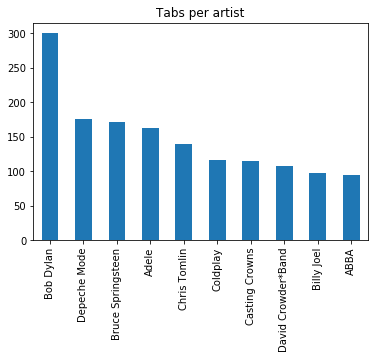

In [15]:
df.artist.value_counts().head(10).plot(kind='bar', title='Tabs per artist')

Lets look at the top artist from this group, Bob Dylan, to get an idea of what a breakdown of all his songs are

number of bob dylan songs in dataset:  152
number of bob dylan songs with multiple versions:  80


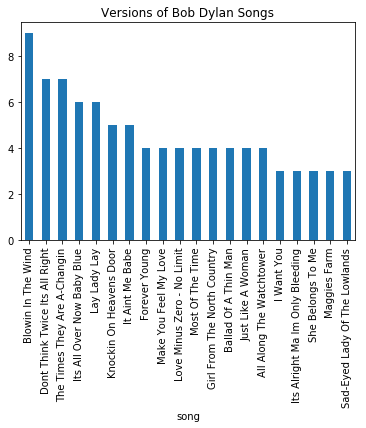

In [16]:
dylan=df[df['artist']=="Bob Dylan"]
dylanSongs=dylan.groupby('song').size().sort_values(ascending=False)
print("number of bob dylan songs in dataset: ", len(dylanSongs))
print("number of bob dylan songs with multiple versions: ",len(dylanSongs[dylanSongs>1]) )
dylanSongs.head(20).plot(kind='bar', title="Versions of Bob Dylan Songs")

Lets look specifically into Blowing in the Wind to see what the differences in each version are

In [17]:
dylan[dylan['song']=='Blowin In The Wind']

,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other
4996,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[D, D, G, D, G, D, D, G, D, G, A, D, G, D, G, ...","[D, G, A, Bm]",Blowin In The Wind,Bob Dylan,"(Folk, Rock)",1960,novice,NaN,NaN,D,NaN
4997,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[C, F, C, Am, C, F, G, G7, C, F, C, Am, C, F, ...","[C, F, Am, G, G7, E7]",Blowin In The Wind,Bob Dylan,"(Folk, Rock)",1960,NaN,E A D G B E,NaN,NaN,NaN
4998,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, C, D, G, C, G, G, C, D, G, C, D, G, C, D, ...","[G, C, D]",Blowin In The Wind,Bob Dylan,"(Folk, Rock)",1960,novice,E A D G B E,7th fret,D,NaN
4999,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[C, D, G, C, D, G, G, C, D, G, C, D, G, C, D, ...","[C, D, G]",Blowin In The Wind,Bob Dylan,"(Folk, Rock)",1960,NaN,NaN,NaN,NaN,NaN
5000,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, C, G, C, G, G, C, G, C, D, G, C, G, C, G, ...","[G, C, D, Em]",Blowin In The Wind,Bob Dylan,"(Folk, Rock)",1960,novice,E A D G B E,6th fret,NaN,NaN
5001,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, G, C, G/B, D/A, G, G, C, G/B, G, G, C, G/B...","[G, C, G/B, D/A, C/B, D/F#, C/G, D]",Blowin In The Wind,Bob Dylan,"(Folk,)",1960,intermediate,E A D G B E,7th fret,D,"Chords for the classic acoustic version from ""..."
5002,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[D, D, G, A, D, G, D, G, A, D, G, A, D, G, A, ...","[D, G, A, Bm]",Blowin In The Wind,Bob Dylan,"(Folk,)",1960,NaN,E A D G B E,NaN,NaN,NaN
5003,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[G, C, G, C, G, G, C, G, C, D, G, C, G, C, G, ...","[G, C, D]",Blowin In The Wind,Bob Dylan,"(Folk,)",1960,NaN,E A D G B E,NaN,NaN,NaN
5004,https://tabs.ultimate-guitar.com/tab/bob-dylan...,"[C, F, C, C, C, F, C, C, C, F, C, C, C, F, C, ...","[C, F, G, Am]",Blowin In The Wind,Bob Dylan,"(Folk,)",1960,novice,E A D G B E,2nd fret,NaN,NaN


Interesting, so looks like there are 9 pretty different versions of the same song. There are a few basic/easy versions where the songs only use C D and G. Theres another version with D G A and Bm. Theres also an intermediate version with some more unique chords...

Lets look at multi-versioned songs on a higher level.

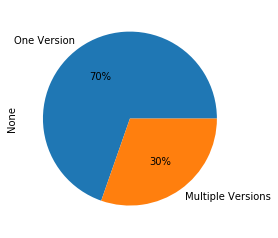

In [18]:
songArtist=df.groupby(['song','artist']).size().sort_values(ascending=False)
# print("Number of unique songs in db: ", len(songArtist))
# print("Number of songs that have multiple versions: ", songArtist[songArtist>1].sum())
# songArtist.head()
songArtist.apply(lambda x: "One Version" if x==1 else "Multiple Versions").value_counts().plot(kind='pie',  autopct='%1.0f%%')


Interesting, so 30% of our songs have multiple versions in this data set. It could be interesting to look at differences across versions at some point!

As a first step though, lets look at which songs have the most versions in this data set.

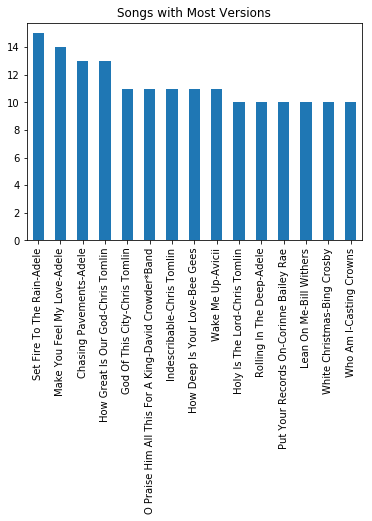

In [19]:
(df['song']+'-'+df['artist']).value_counts().head(15).plot(kind='bar', title='Songs with Most Versions')
# df.song.value_counts().head(10).plot(kind='bar')

Wow Adele really dominates this list, tons of songs with multiple versions.

### Song Difficulties, Tuning, Capo, and Key

On to the next. These values were all gathered in one field listed at the top of the tab.

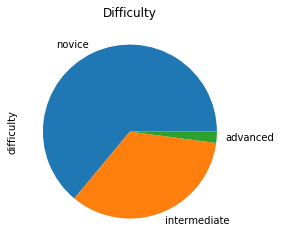

In [20]:
df.difficulty.value_counts().plot(kind='pie', title='Difficulty')

A majority of our songs are novice!

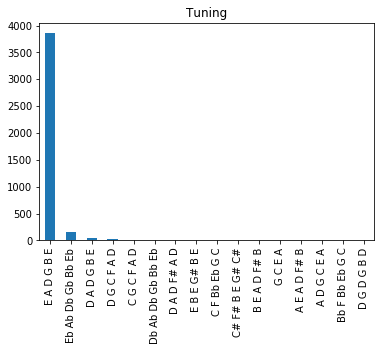

In [21]:
df.tuning.value_counts().plot(kind='bar', title='Tuning')

The large majority of these are in standard tuning. Interesting that the next most popular tuning is just standard tuning shifted a half step down.

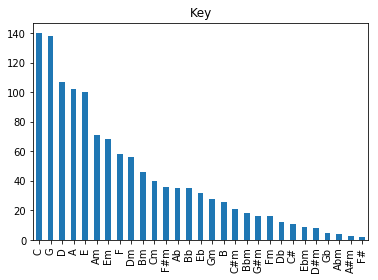

In [22]:
df.key.value_counts().plot(kind='bar', title='Key')

We've got a pretty balanced set of keys here. C and G are certainly the most common though.

## Chords

I honestly don't even know where to start with these, there's so many interesting directions to take this. I think the best way forward will be to just ask some questions about the chords, and try to find answers. This might inform next questions and steps for this project as well.

#### What are the most used chords across all songs?

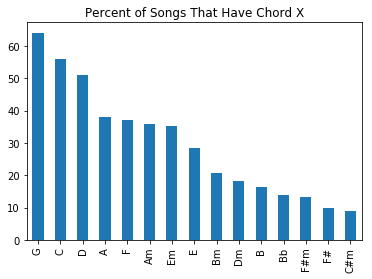

In [23]:
chordList=df.uniqueChords.sum()
((pd.Series(chordList).value_counts().sort_values(ascending=False)/len(df))* 100).head(15).plot(kind='bar', title='Percent of Songs That Have Chord X')

Wow G C and D are all in over 50% of the songs in the DB! This is a great guide for the order you should learn chords. I would have definitely guessed C to be more popular than G.

#### How many unique chords are in this database?

In [24]:
uniqueChords=len(list(set(chordList)))
print("There are {} unique chords used across all songs".format(uniqueChords))

There are 1730 unique chords used across all songs


Is this right?? Are there that many unique chords? Maybe we can check by seeing if chords are used across multiple songs? I would assume if they are only used once in the entire DB of 10k songs, it's likely they are just written in a unique way

Text(0, 0.5, 'Chord Count')

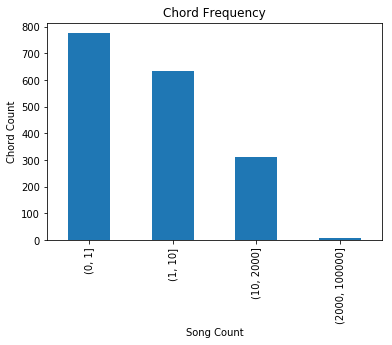

In [25]:
chordCounts=pd.Series(chordList).value_counts().sort_values(ascending=False)
ranges = [0,1,10,2000,100000]
ax=chordCounts.groupby(pd.cut(chordCounts, ranges)).count().plot(kind='bar', title='Chord Frequency')
ax.set_xlabel("Song Count")
ax.set_ylabel("Chord Count")

Interesting, so although we definitely have "common chords" (i.e ones that are used across many songs), we've got plenty of chords that are used very sparsely (i.e only seen in one song). There are likely many ways to clean this up properly, so I'll leave this for future work.

Text(0.5, 1.0, 'Chord Frequency of Use Across Songs')

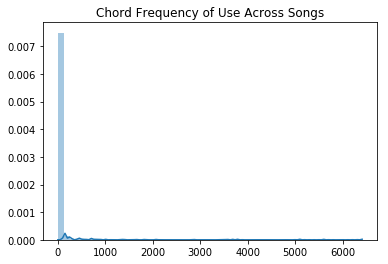

In [26]:
sns.distplot(chordCounts).set_title("Chord Frequency of Use Across Songs")

This is another way of looking at this data. Most chords are used rarely (big spike near 0), while there are small percentages of chords used many times.

#### How many chords do most songs have?


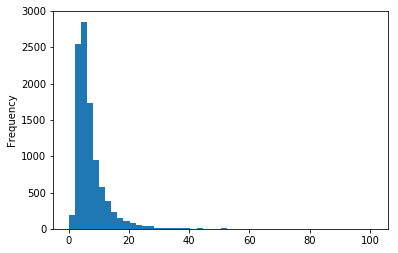

In [27]:
df['cardinality']=df.uniqueChords.apply(lambda x: len(x))
df.cardinality.plot(kind='hist', bins=50)

In [28]:
print('Song Chord Info')
print('Median Cardinality: ', df['cardinality'].median())
print('Max Cardinality: ', df['cardinality'].max())
print('Min Cardinality: ', df['cardinality'].min())

Song Chord Info
Median Cardinality:  6.0
Max Cardinality:  101
Min Cardinality:  0


These cadinality counts are interesting. Looks like we have some data with no chord data at all. We can remove those from our data set. It could also be worth exploring some of these songs with 50 chords! 101 is our max which is really a lot of chords to have for a song...

In [29]:
#remove songs with no chords
print('Old Count of Songs: ', df.shape[0])
df=df[df['cardinality']!=0]
print('Song Chord Info')
print('Median Cardinality: ', df['cardinality'].median())
print('Max Cardinality: ', df['cardinality'].max())
print('Min Cardinality: ', df['cardinality'].min())
print('New Count of Songs (after removing 0 cardinality songs): ', df.shape[0])

Old Count of Songs:  9997
Song Chord Info
Median Cardinality:  6.0
Max Cardinality:  101
Min Cardinality:  1
New Count of Songs (after removing 0 cardinality songs):  9927


Thats's better. Seems we only lost 70 songs also from this, not bad.

#### Do songs often use the same chords?

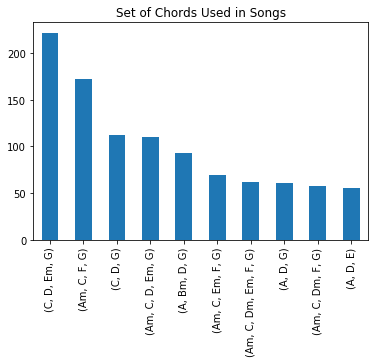

In [30]:
# novChords.value_counts()
df.uniqueChords.apply(sorted).apply(tuple).value_counts().head(10).plot(kind='bar', title='Set of Chords Used in Songs')

So we definitely have quite a few songs that have similar chords. I would imagine that songs with these rather simple chord progressions are mostly novice songs. Lets check this out by breaking down these common groupings by the difficulty group they are found in

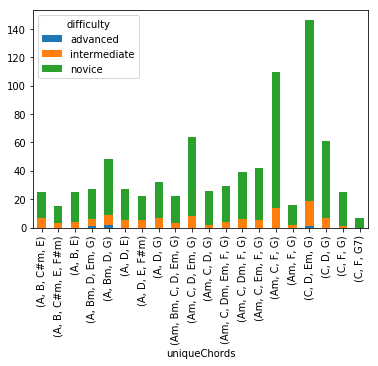

In [31]:
df['uniqueChords']=df.uniqueChords.apply(sorted).apply(tuple)
chordGroups=df.uniqueChords.value_counts().head(20)
dfTest=df[df['uniqueChords'].isin(chordGroups.index.to_list())]
dfTest.groupby(['uniqueChords', 'difficulty']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)

This makes a lot of sense.... It looks like common chord progressions are used in easier songs as expected. It's worth noting that a majority of our songs are from the "novice" difficulty, so our data set is a bit skewed to start. This is still an interesting result regardless. One question I'm interested to see is what makes a song "advanced" if it's using a simple chord progression like (C,D, Em, G). We have a few advanced songs in that group.

Interesting video about the many songs made from one chord progression
https://www.youtube.com/watch?v=2pXS8k1zx8U

In [32]:
temp=df[df['uniqueChords']==('C','D','Em','G')]
temp[temp['difficulty']=='advanced']

,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other,cardinality
6022,https://tabs.ultimate-guitar.com/tab/broods/he...,"[G, D, Em, C, G, D, Em, C, G, D, Em, C, G, D, ...","(C, D, Em, G)",Heartlines,Broods,"(Electronic,)",2010,advanced,NaN,NaN,NaN,NaN,4


I don't see anything advanced about this song! Could bring into question the validity of our difficulty levels for future tasks...

There are really endless more ways we can continue with this EDA, but let's stop for now! Listing out a few more of my question ideas here for potential future use.


* What is the most likely chord to happen after another chord?(i.e what transition should you learn)

* How do chords and transitions differ by genre? (how do chords define genres)

* What chords do you need to know for each difficulty level?

* Top chords per genre, decade, artist?
* Predict the genre or decade based on chords, cardinality, etc?


#### Potential cleaning of chords remaining

* Changing chord names based on capo??
https://www.youtube.com/watch?v=Ky8uOOfI2tY

* Adding key based on chords in song

* Getting numeric notation chord sequence

## 5. Deal with Missing Values

Now that we've done all our necessary cleaning, lets take a quick look at missing values.

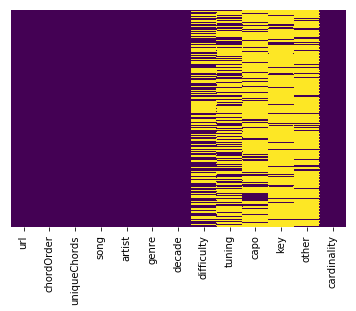

In [33]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

So we've done a great job for the most part already cleaning this up. The only columns that have missing data are ones that came from the "top info section". There are some methods for potentially filling out these columns that I've put below, but for the sake of exporting this data set, I'm going to leave them as is for now. I can deal with nulls if and when I want to use them for a classification task.

- Steal values from other tabs of the same song (genre, decade, etc.) 
- Take data from other column
- Make assumptions about tuning and capo
- Calculate key from chords in song

In [34]:
#some code from my initial look at filling missing values
#use other column to add tunings where missing

# df['other']= df.other.apply(lambda x: x.lower() if isinstance(x, str) else x)
# df.loc[df['other'].str.contains("standard tuning") & df['tuning'].isnull(),
#       'tuning']='E A D G B E'

# check for most used workds in other column
# temp=df[df.other.notnull()]
# word_list=' '.join(temp['other']).lower().split()
# filtered_words =  pd.Series([word for word in word_list if word not in stopwords.words('english')])
# filtered_words.value_counts()[:100]

## 6. Export Data

Lets send this data out! Hopefully someone else gets some use out of this data even if I don't pick it up for future work. I will use both a pkl and a csv to avoid the loss of formatting which I found in the beginning! Let's take one final look at the data set I'll be sending out. It's really come a long way since my initial scrape!

In [35]:
df.head()

,url,chordOrder,uniqueChords,song,artist,genre,decade,difficulty,tuning,capo,key,other,cardinality
0,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[G, C, G, C, D, G, C, G, C, D, G, C, G, C, D, ...","(C, D, G)",Its All Wrong But Its All Right,Dolly Parton,"(Country,)",1970,NaN,NaN,NaN,NaN,NaN,3
1,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, C, G, Am, G, Am, Am, C, G, Am, G, Am, Am,...","(Am, C, G)",Jolene,Dolly Parton,"(Country, Folk)",1970,intermediate,E A D G B E,4th fret,NaN,NaN,3
2,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Em, G, D, Em, D, Em, Em, G, D, Em, Em, G, D, ...","(D, Em, G)",Jolene,Dolly Parton,"(Country,)",1970,novice,E A D G B E,4th fret,NaN,NaN,3
3,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Dm, F, C, Dm, C, Dm, F, C, Dm, C, Dm, Dm, F, ...","(C, Dm, F)",Jolene,Dolly Parton,"(Country, Folk)",1970,NaN,NaN,NaN,NaN,NaN,3
4,https://tabs.ultimate-guitar.com/tab/dolly-par...,"[Am, Am, C, G, Am, G, Am, Am, C, G, Am, G, Em,...","(Am, C, Em, G)",Jolene,Dolly Parton,"(Country, Folk)",1970,novice,E A D G B E,4th fret,C#m,NaN,4


In [36]:
# df.to_csv("/Users/eshantarneja/Documents/DataScience/data/cleanData/cleanData.csv")
# df.to_pickle("/Users/eshantarneja/Documents/DataScience/data/cleanData/cleanData.pkl")